In [1]:
# This notebook is used for testing.
# Aim: Calculate magnetic fields of different coil configuration

In [2]:
#Version1:
#Includes formula for calculating the B-field of a straight line from r_start to r_end at any arbitrary position
#Includes formula to calculate B-field of many straight lines; line segments are specified using a tuple_list
#Includes formula to create tuple_list for a single loop

#Version 2:
#Includes function to create tuple list for N loops with same current I

#Version 3:
#Includes cell to plot the coils in 3D

#Version 4:
#Plotting the coils is now a function
#Includes function to draw B-field in x,y or z plane or any plane perpendicular to those planes.

#Version 5:
#Remove most test cells and clean code

#Version 6:
#Include I into parameter list.
#This required to convert tuple_lists to lists (maybe later also to np.arrays) and change from vectors (np.array(x,y,z)) to vector coordinates x,y,z

#Version 7:
#Include method to calculate B-field gradient numerically along x,y,z-axis
#Correct colorcoding for B-field plot; Color corresponds to B-field magnitude
#Test for MOT-coil QUIPS B -> not consistend with Joost-Sattlers work -> Find error

#Version 8:
#When calculating the B-field at some point and then shifting the coil as well as the point at which the B-field is calculated, the result changes.
# Problem was an error when calculating the angle between the normal vector to the coil piece and the start/end point of the coil piece.
# Problem was solved

#Version 9:
# Calculating the Gradient using higher order polynomials was tested but is not efficient as many datapoints are needed. Best way is to use a small interval in  combination with a linear fit.
# Calculating and plotting the gradient is seperated into two functions

#TODOs:
#Include coils into B-field drawing?
#Gradient calculation with many coils has big errors? Maybe use longer line for fit

In [3]:
import numpy as np
import scipy.constants
import timeit
import transforms3d #To get rotation matrices
import math
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
#Define constants:
mu_0=scipy.constants.mu_0
pi=scipy.constants.pi

In [5]:
#Define some nice functions:
#Function to normalize a vector:
def normalize(a):
    norm = np.linalg.norm(a)
    if norm==0:
        norm = 1
    return a / norm

#Function to get the sign of the angles of two vectors (e_r_01 and e_r_02) with respect to a third one (e_R):
#angles 1 and 2 define the mathematically positive direction
def angle_sign(def_vec1, def_vec2, ref_vec, vec_of_interest):
    x=np.dot(np.cross(def_vec1,def_vec2),np.cross(ref_vec,vec_of_interest))
    if x>0:
        return 1
    else:
        return -1

# Function to create rotation matrix:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis (np.array) by theta radians. See Euler–Rodrigues formula (Wikipedia)
    """
    axis = normalize(axis)
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

#Function to get the rotation angle in a regular polygon:
def theta(N):
    return 2*pi/N


In [6]:
# Function to calculate magnetic field created by a straight piece of wire:
def B_straight_line(r_start,r_end,I,r_0):
    '''r_0 is the point where the B-field is calculated, the wire starts at r_start and ends at r_end, I is the current from r-start to r_end'''
    #Define vectors and corresponding unit vectors:    
    r_01=r_start-r_0
    e_r_01=normalize(r_01)
    #print(r_01)
    #print(e_r_01)
    r_02=r_end-r_0
    e_r_02=normalize(r_02)
    #print(e_r_02)
    r_wire=r_end-r_start
    e_r_wire=normalize(r_wire)
    #print(e_r_wire)
    #e_R is the unit vector from r_0 which is perpendicular to r_wire
    e_R=normalize(np.cross(r_wire,np.cross(r_01,r_wire)))#/(np.linalg.norm(r_wire)*np.linalg.norm(np.cross(r_01,r_wire)))
    #print(normalize(e_R))
    #R is the vector from r_O to the wire with correct length
    R=np.linalg.norm(np.dot(r_01,e_R))*e_R
    #print(R)
    
    #Find angles of r_start and r_end with respect to e_R:
    #Problem: By just taking the vector product or the dot product you get only positive angles. So the dot product between e_r_01 and e_r_02 is used to define a right-handed system. If the dot-product of e_R with e_r_01/e_r_02 is in the same direction, their angle is positive with respect to e_R. -> See Function angle_sign(). 
    alpha_1=angle_sign(e_r_01,e_r_02,e_R,e_r_01)*np.arccos((np.linalg.norm(np.cross(r_start,r_wire)))/(np.linalg.norm(r_start)*np.linalg.norm(r_wire)))
    alpha_2=angle_sign(e_r_01,e_r_02,e_R,e_r_02)*np.arccos((np.linalg.norm(np.cross(r_end,r_wire)))/(np.linalg.norm(r_end)*np.linalg.norm(r_wire)))
    #print(alpha_1,alpha_2)
    
    alpha_1_x=angle_sign(e_r_01,e_r_02,e_R,e_r_01)*np.arccos(np.clip(np.dot(e_r_01, e_R), -1.0, 1.0))
    alpha_2_x=angle_sign(e_r_01,e_r_02,e_R,e_r_02)*np.arccos(np.clip(np.dot(e_r_02, e_R), -1.0, 1.0))
    #print(alpha_1_x,alpha_2_x)
    
    #Get the unit vector of the B-field
    e_t=np.cross(e_R,e_r_wire)
        
    return mu_0*I/(4*pi*np.linalg.norm(R))*(np.sin(alpha_2_x)-np.sin(alpha_1_x))*e_t

In [7]:
#Formula for a circular loop with radius R, B-field measured on axis with distance z to the plane of the loop
def B_circular_loop_onaxis(z,R,I):
    return mu_0*I*R**2/(2*np.power(R**2+z**2,1.5))

#To check the formula, using a square loop with edge length a=0.1m, current I=1A and the B-field is measured at the symmetry axis in the plane of the loop
#Wikipedia, Biot-Savart says for a square loop on the symmetry axis and in the plane of the loop:
def square_loop_wikicheck(a,I):
    return (mu_0*I*2/pi)*np.sqrt(2/(a**2))

In [8]:
#Calculate B-field for snippets of straight wires described by tuples [r_start,r_end]
def B_field(vec_curr_list,r_0):
#Map the vector tuples onto the vector arguments of B_straight line (r_start,r_end) and add all resulting B-field vectors together
    #r_start=r_s; r_end=r_e
    return np.sum((map(lambda (r_s_x,r_s_y,r_s_z,r_e_x,r_e_y,r_e_z,I): B_straight_line(np.array([r_s_x,r_s_y,r_s_z]),np.array([r_e_x,r_e_y,r_e_z]),I,r_0), vec_curr_list)), axis=0)

In [9]:
#Create a function that creates list of vector tuples of one regular polygon loop:
def tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in,I):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    r_center: vector defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #r_center=np.array([r_center_x,r_center_y,r_center_z])
    #Test that e_start and e_normal are perpendicular
    if 0.0!=np.dot(r_normal,r_start_side):
        print("vectors are not perpendicular!")
    e_normal=normalize(r_normal)
    e_start_side=normalize(r_start_side)
    r_out=r_in/(np.cos(pi/N))
    e_start_corner=np.dot(rotation_matrix(e_normal,theta(N)/2),e_start_side) 
    r_start_corner=r_out*e_start_corner

    #Create list of vector lists:
    #Use the starting edge vector and rotate it around the symmetry axis by 2pi/N to get the next corner. Every segment goes from one to the next corner.
    vec_curr_list=[]
    for i in range(N):
        r_start_i=r_center+np.dot(rotation_matrix(e_normal,i*theta(N)),r_start_corner)
        r_end_i=r_center+np.dot(rotation_matrix(e_normal,(i+1)*theta(N)),r_start_corner)
        vec_curr_list.append([r_start_i[0],r_start_i[1],r_start_i[2],r_end_i[0],r_end_i[1],r_end_i[2],I])
    
    #vec_curr_list=[[r_center+np.dot(rotation_matrix(e_normal,i*theta(N)),r_start_corner),r_center+np.dot(rotation_matrix(e_normal,(i+1)*theta(N)),r_start_corner),I] for i in range(N)]
    return vec_curr_list

In [10]:
#Function to create tuple_list for several regular polygon loops with changing parameters r_center,r_in and fixed parameters N,r_normal,r_start_side
def tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    param_list: parameter list with tuples (r_center,r_in) where
    r_c_i: vector coord. defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #Create a list of single loop tuple lists 
    list_of_tuple_lists=map(lambda (r_c_x,r_c_y,r_c_z,r_in,I):tuple_list_single_loop(N,r_normal,r_start_side,np.array([r_c_x,r_c_y,r_c_z]),r_in,I),loop_param_list)
    #Flatten the list to one big list
    flattend_tuple_list=list(itertools.chain.from_iterable(list_of_tuple_lists))
    return flattend_tuple_list

In [11]:
#Convert tuple_list into np.array with x,y,z where x,y and z are 1D arrays that can be used for 3D plotting of the loop
def tuple_list_converter(tuple_list):
    #convert tuple_list to array and choose only vectors of wire
    vec_tuple_array=np.array(tuple_list)
    #print(vec_tuple_array.shape)
    #Check that tuple list has correct form:
    n,t=np.shape(vec_tuple_array)
    if t!=7 or n==0:
        print('Tuple list has not correct shape')
    #Rearrange array, such that it consists of three 1D arrays
    rearranged_tuple_array=vec_tuple_array[:,0:6].reshape(n*2,3).T
    return rearranged_tuple_array

In [12]:
#Function to plot the current loop
def loop_plot(N,r_normal,r_start_side,param_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    threeD_array=tuple_list_converter(tuple_list_N_loop(N,r_normal,r_start_side,param_list))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(threeD_array[0],threeD_array[1],threeD_array[2],zdir='z')
    plt.savefig('loop_plot_test.pdf')
    plt.show()
    return

In [13]:
#Function to plot the B-field in two dimensions:
def B_plot(N,r_normal,r_start_side,loop_param_list,x,y,z):
    '''N: number of edges of one loop
    r_normal: normal vector of coil area
    r_start_side: vector defining rotational orientation around r_normal
    param_list: parameter list r_center=vector to loop center,r_in=inner radius of loop
    I: loop current
    x,y,z: parameter space for x,y,z defined using np.linspace(); as only a 2D plot is possiple, for one axis y=np.linspace(a,a,1)
    '''
    #Check which axis shall be plotted:
    if np.size(x)==1:
        a1,a2=y,z
        p_coord=0 #Plane coord
        B_coord1,B_coord2=1,2
        xlabel,ylabel='y','z'
        const_label=' x = '
        axis_const=x[0]
    elif np.size(y)==1:
        a1,a2=x,z
        p_coord=1 #plane coord
        B_coord1,B_coord2=0,2
        xlabel,ylabel='x','z'
        const_label=' y = '
        axis_const=y[0]
    elif np.size(z)==1:
        a1,a2=x,y
        p_coord=2 #plane_coord
        B_coord1,B_coord2=0,1
        xlabel,ylabel='x','y'
        const_label=' z = '
        axis_const=z[0]
    else:
        print('You have chosen the wrong parameter space x,y,z for plotting')
    
    tuple_list=tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list)
    
    #Find all loop segments intersecting the plotted plane:
    plane_intersection_coord_list=[]
    for m in range(len(tuple_list)):
        i=tuple_list[m]
        if np.sign(i[p_coord])!=np.sign(i[p_coord+3]):
            a=np.absolute(i[p_coord])/(np.absolute(i[p_coord])+np.absolute(i[p_coord+3]))
            f=lambda i:[a*i[0]+(1-a)*i[3],a*i[1]+(1-a)*i[4],a*i[2]+(1-a)*i[5]]
            plane_intersection_coord_list.append(f(i))
    #Round the values:        
    plane_intersection_coord_array=np.round(np.array(plane_intersection_coord_list),8).T
    #print(plane_intersection_coord_array)
    
    
    #Create a meshgrid from the given parameter space for plotting:
    g = np.meshgrid(x, y, z)
    #Create a list with all position vectors given by the meshgrid:
    positions = np.vstack(map(np.ravel, g)).T

    #Create a B-field matrix containing the B-field vectors at the positions vectors
    B=np.zeros(np.shape(positions))
    for i in range(np.shape(positions)[0]):
        B[i]=B_field(tuple_list,positions[i])
    
    #Convert the 1D array of B-field vectors back into a meshgrid-like structure as needed for plotting:
    #Use np.transpose for that because B has shape (n,m,3) and needs (m,n,3)
    B_transp=np.transpose(np.reshape(B,(np.shape(a1)[0],np.shape(a2)[0],3)),(1,0,2))
    #Note that B_x=B[:,:,0],B_y=B[:,:,1],B_z=B[:,:,2]
    
    #Calculate B-field magnitude for whole grid for color plot
    B_magnitude=np.empty((B_transp.shape[0],B_transp.shape[1]))
    for i in range(B_transp.shape[0]):
        for j in range(B_transp.shape[1]):
            B_magnitude[i,j]=np.sqrt(B_transp[i,j,0]**2+B_transp[i,j,1]**2+B_transp[i,j,2]**2)
    
    #Code for plotting
    fig=plt.figure()
    im = plt.streamplot(a1,a2,B_transp[:,:,B_coord1],B_transp[:,:,B_coord2], color=B_magnitude, linewidth=2, cmap='rainbow')
    fig.colorbar(im.lines)
    plt.plot(plane_intersection_coord_array[B_coord1],plane_intersection_coord_array[B_coord2],'ro',ms=0.002)
    plt.xlabel(xlabel+'-axis')
    plt.ylabel(ylabel+'-axis')
    
    plt.title('B-field for'+const_label+str(axis_const))
    plt.savefig('B_field_test.pdf')
    plt.show()
    

In [71]:
#Functions to calculate and plot the B-field gradient:

def B_gradient_calc(N,r_normal,r_start_side,loop_param_list,grad_range,n,axis):
        
    positions=np.zeros((n,3))
    positions[:,axis]=np.array(np.linspace(-grad_range,grad_range,n))
    #print(positions)
    
    B_grad=np.zeros(np.shape(positions))
    for i in range(np.shape(positions)[0]):
        B_grad[i]=B_field(tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list),positions[i])
    #print(B_grad)
    #Get fit values as well as covariance matrix; The diagonal elements of the covariance matrix are the variances of the fit values
    # The standard deviation is given by the square root of the variance
    fit_dim=1
    fit,cov=np.polyfit(positions[:,axis],B_grad[:,axis],fit_dim,cov=True)
    #print(fit,cov)
    axis_name=['x','y','z']
    print('The gradient in ' +axis_name[axis]+ '-direction is: '+str(fit[fit_dim-1])+' +/- '+str(np.sqrt(cov[fit_dim-1,fit_dim-1]))+' T/m.')
    print('The gradient in ' +axis_name[axis]+ '-direction is: '+str(fit[fit_dim-1]*100)+' +/- '+str(np.sqrt(cov[fit_dim-1,fit_dim-1])*100)+' G/cm.')
    
def B_gradient_plot(N,r_normal,r_start_side,loop_param_list,grad_range,n,axis,filename):
    positions=np.zeros((n,3))
    positions[:,axis]=np.array(np.linspace(-grad_range,grad_range,n))
    #print(positions)
    
    B_grad=np.zeros(np.shape(positions))
    for i in range(np.shape(positions)[0]):
        B_grad[i]=B_field(tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list),positions[i])
    #print(B_grad)
    #Plotting section
    axis_name=['x','y','z']
    fig_grad=plt.figure()
    plt.plot(positions[:,axis],B_grad[:,axis])
    plt.xlabel('Position on '+str(axis_name[axis])+' axis')
    plt.ylabel('B-field (T)')
    
    plt.title('B-field for '+str(axis_name[axis])+' axis')
    plt.savefig('B_gradient_'+filename+'.pdf')
    plt.show()

In [72]:
# Function to create triangular coils for positive or negative distance from coil center in the whole coil:
#Triangle has its legs along the radial axis and the z-axis(symmetry-axis of the coil)
def param_list_creator_triangle(r_center_0,r_in_0,n,loop_sep,I,negative):
    loop_param_list=[]
    # Use a parameter c to add or subtract distances for the following coils in a for-loop
    if negative==True:
        c=-1
    else: c=1
    #r_center_0=np.array([0,0,0.0293])
    #I=1
    #r_in_0=0.0321+0.0005
    for i in range(n):
        for j in range(i+1):
            r=r_center_0+c*np.array([0,0,(j*loop_sep)+0.0005])
            r_in=r_in_0+(i*loop_sep)
            loop_param_list.append([r[0],r[1],r[2],r_in,I])
    return loop_param_list

#Another triangular configuration with loops: 1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,...
def param_list_creator_triangle_1(r_center_0,r_in_0,n,loop_sep,I,negative):
    loop_param_list=[]
    # Use a parameter c to add or subtract distances for the following coils in a for-loop
    if negative==True:
        c=-1
    else: c=1
    #r_center_0=np.array([0,0,0.0293])
    #I=1
    #r_in_0=0.0321+0.0005
    for i in range(n*2-2):
        x=(i+i%2)-((i+i%2)/2-1)
        for j in range(x):
            #x=(y+y%2)-((y+y%2)/2-1)
            r=r_center_0+c*np.array([0,0,(i*np.sqrt(3)/2*loop_sep)+0.0005])
            r_in=r_in_0+(j*np.sqrt(3)*loop_sep)
            loop_param_list.append([r[0],r[1],r[2],r_in,I])
    return loop_param_list

# Function to create rectangular coils with positive or negative current in the whole coil:
#m: number of coils along z-axis(symmetry-axis)
#n: number of coils in radial direction
def param_list_creator_rect(r_center_0,r_in_0,m,n,loop_sep,I,negative):
    loop_param_list=[]
    # Use a parameter c to add or subtract distances for the following coils in a for-loop
    if negative==True:
        c=-1
    else: c=1
    #r_center_0=np.array([0,0,0.0293])
    #I=1
    #r_in_0=0.0321+0.0005
    for i in range(n):
        for j in range(m):
            r=r_center_0+c*np.array([0,0,(j*loop_sep)+0.0005])
            r_in=r_in_0+(i*loop_sep)
            loop_param_list.append([r[0],r[1],r[2],r_in,I])
    return loop_param_list


In [17]:
#General Test area:
r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=8
r_0=np.array([0,0,0])

#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
#loop_param_list_1=[[0,0,1,1,1],[0,0,-1,1,-1]]#,(np.array([0,0,-1]),1)
#loop_param_list_2=[[0,0,1,1,2],[0,0,-1,1,-2]]#,(np.array([0,0,-1]),1)
r_center_0=np.array([0,0,0.0293])
I=5.8
r_in_0=0.0321+0.0005
m=3
n=3
loop_param_list_plus=param_list_creator_rect(r_center_0,r_in_0,m,n,0.0014,I,False)
loop_param_list_minus=param_list_creator_rect(-r_center_0,r_in_0,m,n,0.0014,-I,True)
loop_param_list_comb=loop_param_list_plus + loop_param_list_minus


y=np.linspace(-2.5,2.5,19)
x=np.linspace(0,0,1)
z=np.linspace(-4,4,19)

#Plotting functions
#B_plot(N,r_normal,r_start_side,loop_param_list_comb,x,y,z)
#loop_plot(N,r_normal,r_start_side,loop_param_list_1)

#grad_range=0.2
#n=11
#axis=2
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_1,grad_range,n,axis)
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_1,grad_range,n,0)
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_1,grad_range,n,1)

The gradient in z-direction is: 0.217815029943 +/- 4.23688573914e-06 T/m.
The gradient in z-direction is: 21.7815029943 +/- 0.000423688573914 G/cm.


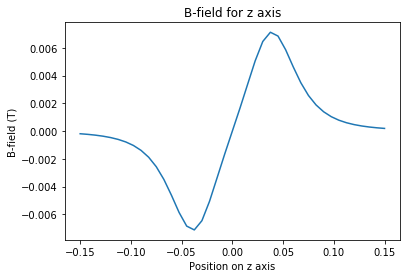

In [74]:
#MOT-Coil Quips B:

#Values Joost Sattler:
#Create loop_param_list for triangle with
#r_center=+/- [0,0,0.0293]
#r_außen=47,3mm
#Schenkellänge=15.2mm
#Drahtdurchmesser=1mm
#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
r_center_0=np.array([0,0,0.0293])
I=5.8
r_in_0=0.03221+0.0005
n=9
line_sep=0.001
loop_param_list_plus=param_list_creator_triangle_1(r_center_0,r_in_0,n,line_sep,I,False)
loop_param_list_minus=param_list_creator_triangle_1(-r_center_0,r_in_0,n,line_sep,-I,True)
loop_param_list_comb=loop_param_list_plus + loop_param_list_minus
#print(len(loop_param_list_plus))
#print(loop_param_list_plus[-9],loop_param_list_plus[-1])
#axial distance between center of first and last loop
#print(loop_param_list_plus[0][2]-loop_param_list_plus[-1][2])
#radial distance between center of first and last loop
#print(loop_param_list_plus[0][3]-loop_param_list_plus[-1][3])

r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=32
#r_0=np.array([0,0,0])

#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
#loop_param_list_1=[[0,0,1,1,1],[0,0,-1,1,-1]]#,(np.array([0,0,-1]),1)
#loop_param_list_2=[[0,0,1,1,2],[0,0,-1,1,-2]]#,(np.array([0,0,-1]),1)


y=np.linspace(-0.06,0.06,19)
x=np.linspace(0,0,1)
z=np.linspace(-0.06,0.06,19)

#Plotting functions
#B_plot(N,r_normal,r_start_side,loop_param_list_comb,x,y,z)
#loop_plot(N,r_normal,r_start_side,loop_param_list_comb)

grad_range_calc=0.001
n_calc=11
grad_range_plot=0.15
n_plot=41
B_gradient_calc(N,r_normal,r_start_side,loop_param_list_comb,grad_range_calc,n_calc,2)
B_gradient_plot(N,r_normal,r_start_side,loop_param_list_comb,grad_range_plot,n_plot,2,'QUIPS_B_MOT_triangle_1')


Result for MOT field of QUIPS B with traingle_1 configuration (1,2,2,3,3,...,8,8,9=80 coils):<br/>
```
r_center_0=np.array([0,0,0.0293])
I=5.8
r_in_0=0.03221+0.0005
n=9
line_sep=0.001```
Schenkellänge radial: 14.85mm<br/>
Schenkellänge axial: 13.99mm<br/>
The gradient in z-direction is: 0.217815029943 +/- 4.23688573914e-06 T/m.
The gradient in z-direction is: 21.7815029943 +/- 0.000423688573914 G/cm.

78
([0.0, 0.0, 0.033700000000000001, 0.0469, 5.8], [0.0, 0.0, 0.0441, 0.0469, 5.8])
-0.0143
-0.0143
The gradient in z-direction is: 0.220257430553 +/- 1.37350683694e-06 T/m.
The gradient in z-direction is: 22.0257430553 +/- 0.000137350683694 G/cm.


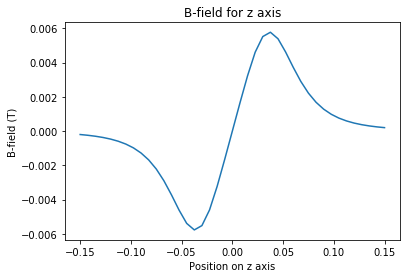

In [75]:
#MOT-Coil Quips B:

#Values Joost Sattler:
#Create loop_param_list for triangle with
#r_center=+/- [0,0,0.0293]
#r_außen=47,3mm
#Schenkellänge=15.2mm
#Drahtdurchmesser=1mm
#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
r_center_0=np.array([0,0,0.0293])
I=5.8
r_in_0=0.0321+0.0005
n=12
line_sep=0.0013
loop_param_list_plus=param_list_creator_triangle(r_center_0,r_in_0,n,line_sep,I,False)
loop_param_list_minus=param_list_creator_triangle(-r_center_0,r_in_0,n,line_sep,-I,True)
loop_param_list_comb=loop_param_list_plus + loop_param_list_minus
print(len(loop_param_list_plus))
#print(loop_param_list_comb[0],loop_param_list_comb[-1])
print(loop_param_list_plus[-9],loop_param_list_plus[-1])
#axial distance between center of first and last loop
print(loop_param_list_plus[0][2]-loop_param_list_plus[-1][2])
#radial distance between center of first and last loop
print(loop_param_list_plus[0][3]-loop_param_list_plus[-1][3])

r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=32
#r_0=np.array([0,0,0])

#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
#loop_param_list_1=[[0,0,1,1,1],[0,0,-1,1,-1]]#,(np.array([0,0,-1]),1)
#loop_param_list_2=[[0,0,1,1,2],[0,0,-1,1,-2]]#,(np.array([0,0,-1]),1)


y=np.linspace(-0.06,0.06,19)
x=np.linspace(0,0,1)
z=np.linspace(-0.06,0.06,19)

#Plotting functions
#B_plot(N,r_normal,r_start_side,loop_param_list_comb,x,y,z)
#loop_plot(N,r_normal,r_start_side,loop_param_list_comb)

grad_range_calc=0.001
n_calc=11
grad_range_plot=0.15
n_plot=41
B_gradient_calc(N,r_normal,r_start_side,loop_param_list_comb,grad_range_calc,n_calc,2)
B_gradient_plot(N,r_normal,r_start_side,loop_param_list_comb,grad_range_plot,n_plot,2,'QUIPS_B_MOT_triangle')


Result for MOT field of QUIPS B with traingle_1 configuration (1,2,3,...,12=78 coils):<br/>
```
r_center_0=np.array([0,0,0.0293])
I=5.8
r_in_0=0.0321+0.0005
n=12
line_sep=0.0013
```
Schenkellänge radial und axial: 15.3mm<br/>
The gradient in z-direction is: 0.220257430553 +/- 1.37350683694e-06 T/m.
The gradient in z-direction is: 22.0257430553 +/- 0.000137350683694 G/cm.

40
([0.0, 0.0, 0.043000000000000003, 0.08275, 1], [0.0, 0.0, 0.044500000000000005, 0.08725000000000001, 1])
-0.0015
-0.0045


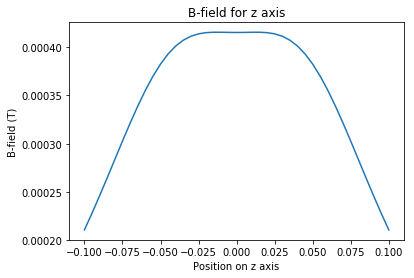

In [84]:
#Kompensation coils Quips B; z-axis:
#inner radius:82.5mm
#outer radius:88mm
#distance between coils: 85mm

#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
r_center_0=np.array([0,0,0.0425])
I=1
r_in_0=0.0825+0.00025
n=4
m=10
line_sep=0.0005
loop_param_list_plus=param_list_creator_rect(r_center_0,r_in_0,n,m,line_sep,I,False)
loop_param_list_minus=param_list_creator_rect(-r_center_0,r_in_0,n,m,line_sep,I,True)
loop_param_list_comb=loop_param_list_plus + loop_param_list_minus
print(len(loop_param_list_plus))
#print(loop_param_list_comb[0],loop_param_list_comb[-1])
print(loop_param_list_plus[0],loop_param_list_plus[-1])
#axial distance between center of first and last loop
print(loop_param_list_plus[0][2]-loop_param_list_plus[-1][2])
#radial distance between center of first and last loop
print(loop_param_list_plus[0][3]-loop_param_list_plus[-1][3])

r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=32
#r_0=np.array([0,0,0])

#loop_param_list=[[r_c_1_x,r_c_1_y,r_c_1_z,r_in_1,I_1],...]
#loop_param_list_1=[[0,0,1,1,1],[0,0,-1,1,-1]]#,(np.array([0,0,-1]),1)
#loop_param_list_2=[[0,0,1,1,2],[0,0,-1,1,-2]]#,(np.array([0,0,-1]),1)


y=np.linspace(-0.06,0.06,19)
x=np.linspace(0,0,1)
z=np.linspace(-0.06,0.06,19)

#Plotting functions
#B_plot(N,r_normal,r_start_side,loop_param_list_comb,x,y,z)
#loop_plot(N,r_normal,r_start_side,loop_param_list_comb)

grad_range_1=0.1
grad_range_2=0.01
grad_range_3=0.001
o=41
B_gradient_plot(N,r_normal,r_start_side,loop_param_list_comb,grad_range_1,o,2,'comp_field_z_axis')
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_comb,grad_range_2,n,2)
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_comb,grad_range_3,n,2)
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_1,grad_range,n,0)
#B_gradient_calc(N,r_normal,r_start_side,loop_param_list_1,grad_range,n,1)

In [ ]:

loop_param_list_1=[[0.0,0,0,0.2,1]]
loop_param_list_2=[[0,0,0.1,0.2,-1],[0,0,-0.1,0.2,-1]]
loop_param_list_3=[[0,0,-0.2,0.2/np.sqrt(3),1],[0,0,0,0.2/np.sqrt(3),-1]]
r_normal=np.array([1,0,0])
r_start_side=np.array([0,1,0])
N=128

print(B_field(tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list_1),np.array([0.1,0,0])))
print(B_field(tuple_list_N_loop(N,r_normal,r_start_side,loop_param_list_3),np.array([0,0,-0.1])))
#Check Anti-Helmholtz with distance between coils = sqrt(3)*R using Wikipedia formula "Maxwell-Spule":
print(B_gradient_calc(N,r_normal,r_start_side,loop_param_list_3,0.01,41,2))


In [39]:
print(1+2+2+3+3+4+4+5+5+6+6+7+7+8+8+9)
print(12*13/2)

80
78
